<a href="https://colab.research.google.com/github/domywillygithub/Codes/blob/main/Augmentation_in_Image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of handwritten digits using various neural network models with PyTorch
* Multinomial classification task of images of handwritten digits (10 classes).
* The database has a training set of 60k examples, and a test set of 10k examples, each image is of 28x28 pixels size.
* The MNIST ("Modified National Institute of Standards and Technology") is the “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms.

## Model setup

Before we start we need to load libraries and setup the model parameters

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import skimage

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

model_args = {}
# random seed
model_args['seed'] = 123
# we will use batch size of 128 in Stochastic Gradient Descent (SGD) optimization of the network
model_args['batch_size'] = 128 
# learning rate is how fast it will descend
model_args['lr'] = .05
# SGD momentum (default: .5) momentum is a moving average of gradients (it helps to keep direction) 
model_args['momentum'] = .5
# the number of epochs is the number of times you go through the full dataset 
model_args['epochs'] = 20
# logging frequency
model_args['log_interval'] = 100

# Download the dataset

In [2]:
# alternatively just download MNIST.tar.gz archive
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2023-05-29 10:44:22--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2023-05-29 10:44:22--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [            <=>     ]  33.20M  14.4MB/s    in 2.3s    

2023-05-29 10:44:25 (14.4 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

## Normal Transforms before applying geometric transformation

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), 
                              transforms.Normalize((0.1307,), (0.3081,))])
mnist_train = datasets.MNIST('./', train=True, download=False, transform=transform)
# we divide this data into training and validation subsets
train_subset, validation_subset = torch.utils.data.random_split(mnist_train, [50000, 10000])
test_subset = datasets.MNIST('./', train=False, download=False, transform=transform)

## Applying geometric transformation but with rotation less than 45 degree

In [3]:
# Define the additional transformations
additional_transforms = [
    transforms.RandomRotation(15),  # Rotate the image by a random angle up to 15 degrees
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),  # Randomly crop and resize the image to 28x28 pixels
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),  # Randomly translate the image by a fraction of its size
]

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.RandomApply(additional_transforms, p=0.5),  # Apply a random transformation from the additional_transforms list with a 50% probability
])
transform1 = transforms.Compose([transforms.ToTensor(), 
                              transforms.Normalize((0.1307,), (0.3081,))])
mnist_train = datasets.MNIST('./', train=True, download=False, transform=transform)
# we divide this data into training and validation subsets
train_subset, validation_subset = torch.utils.data.random_split(mnist_train, [50000, 10000])
test_subset = datasets.MNIST('./', train=False, download=False, transform=transform1)

## Applying geometric transformation but with rotation greater than 45 degree

In [10]:
# Define the additional transformations
additional_transforms = [
    transforms.RandomRotation(60),  # Rotate the image by a random angle up to 15 degrees
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),  # Randomly crop and resize the image to 28x28 pixels
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),  # Randomly translate the image by a fraction of its size
]

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.RandomApply(additional_transforms, p=0.5),  # Apply a random transformation from the additional_transforms list with a 50% probability
])
transform1 = transforms.Compose([transforms.ToTensor(), 
                              transforms.Normalize((0.1307,), (0.3081,))])
mnist_train = datasets.MNIST('./', train=True, download=False, transform=transform)
# we divide this data into training and validation subsets
train_subset, validation_subset = torch.utils.data.random_split(mnist_train, [50000, 10000])
test_subset = datasets.MNIST('./', train=False, download=False, transform=transform1)

In [11]:
# define dataloaders
loader_kwargs = {'batch_size': model_args['batch_size'], 
                 'num_workers': 2, 
                 'pin_memory': True, 
                 'shuffle': True}
train_loader = torch.utils.data.DataLoader(train_subset, **loader_kwargs)
validation_loader = torch.utils.data.DataLoader(validation_subset, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_subset, **loader_kwargs)

Plot sample images

50000
10000
10000
391
torch.Size([28, 28])


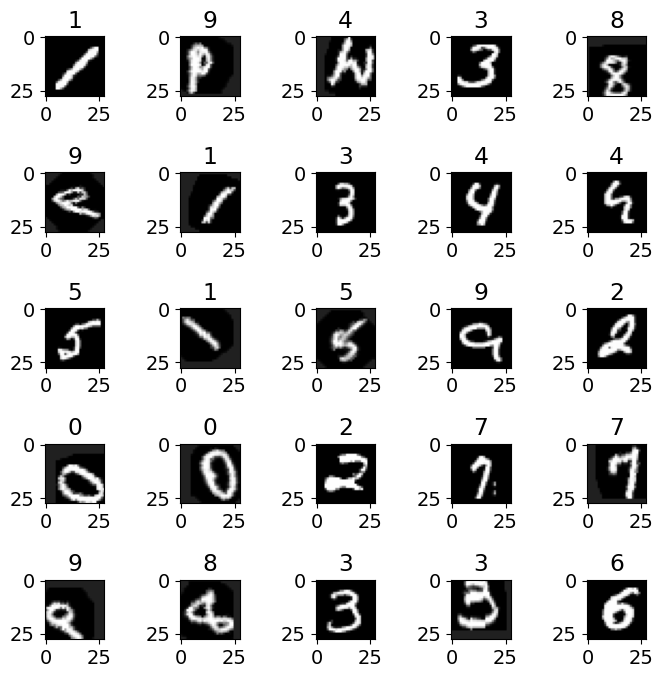

In [13]:
print(len(train_subset))
print(len(validation_subset))
print(len(test_subset)) # we have data already divided into train & validation & test subsets
print(len(train_loader)) # no of train batches
example_number = 123
print(train_subset[example_number][0][0].shape) # single item shape

fig, axs = plt.subplots(5, 5, figsize=(7,7), tight_layout=True)
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(train_subset[example_number+i*5+j][0].reshape(28,28), cmap='gray')
        axs[i,j].set_title(train_subset[example_number+i*5+j][1])

Let's now construct the NN models:
- we start with siplest single layer **perceptron** with *softmax* activation,
- then test **deep** network with some (fully-connected) *hidden* layers,
- and finally setup deep **convolutional neural network**.

In [14]:
class Perceptron(nn.Module):
    # this defines the structure of the Perceptron model
    def __init__(self):
        super(Perceptron, self).__init__()
        # fully connected layer
        self.fc = nn.Linear(28*28, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc(x)
        return F.log_softmax(x, dim=1) # note that dim=0 is the number of samples in batch
    
class Deep(nn.Module):
    def __init__(self):
        super(Deep, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=128)
        self.fc4 = nn.Linear(in_features=128, out_features=64)
        self.fc5 = nn.Linear(in_features=64, out_features=10)

        self.dropout = nn.Dropout(0.2)  # add dropout with probability 0.2

    def forward(self, x):
        x = x.view(x.shape[0], -1)  # flatten the input tensor
        x = F.relu(self.dropout(self.fc1(x)))
        x = F.relu(self.dropout(self.fc2(x)))
        x = F.relu(self.dropout(self.fc3(x)))
        x = F.relu(self.dropout(self.fc4(x)))
        x = self.fc5(x)
        return F.log_softmax(x, dim=1)   

    
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, padding=1) 
        self.bn1 = nn.BatchNorm2d(num_features=128)

        self.tns1 = nn.Conv2d(in_channels=128, out_channels=8, kernel_size=1, padding=1)

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1) 
        self.bn2 = nn.BatchNorm2d(num_features=16)  
        self.pool1 = nn.MaxPool2d(2, 2)   
        

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1) 
        self.bn3 = nn.BatchNorm2d(num_features=16) 
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1) 
        self.bn4 = nn.BatchNorm2d(num_features=32)
        self.pool2 = nn.MaxPool2d(2, 2) 

        self.tns2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=1, padding=1)

        self.conv5 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1) 
        self.bn5 = nn.BatchNorm2d(num_features=16) 
        self.conv6 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1) 
        self.bn6 = nn.BatchNorm2d(num_features=32)

        self.conv7 = nn.Conv2d(in_channels=32, out_channels=10, kernel_size=1, padding=1)    
        
        self.gpool = nn.AvgPool2d(kernel_size=7)

        self.drop = nn.Dropout2d(0.1)


        

    def forward(self, x):
        x = self.tns1(self.drop(self.bn1(F.relu(self.conv1(x)))))
        x = self.drop(self.bn2(F.relu(self.conv2(x))))

        x = self.pool1(x)

        x = self.drop(self.bn3(F.relu(self.conv3(x))))        
        x = self.drop(self.bn4(F.relu(self.conv4(x))))

        x = self.tns2(self.pool2(x))

        x = self.drop(self.bn5(F.relu(self.conv5(x))))
        x = self.drop(self.bn6(F.relu(self.conv6(x))))

        x = self.conv7(x)
        x = self.gpool(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=1)

And define training, testing, and plotting utils:

In [7]:
def train(model, device, train_loader, optimizer, epoch_number):
    model.train()
    train_loss = 0.
    # get subsequent batches over the data in a given epoch
    for batch_idx, (data, target) in enumerate(train_loader):
        # send data tensors to GPU (or CPU)
        data, target = data.to(device), target.to(device)
        # this will zero out the gradients for this batch
        optimizer.zero_grad()
        # this will execute the forward() function
        output = model(data)
        # calculate the negative-log-likelihood loss
        loss = F.nll_loss(output, target, reduction='mean')
        # backpropagate the loss
        loss.backward()
        # update the model weights (with assumed learning rate)
        optimizer.step()
        if batch_idx % model_args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch_number, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        train_loss += loss.item()
    train_loss /= len(train_loader)
    print('\nTrain set: Average loss: {:.4f}'.format(train_loss))
    return train_loss
    
def test(model, device, test_loader, message):
    model.eval()
    test_loss = 0.
    correct = 0
    # this is just inference, we don't need to calculate gradients
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device) 
            output = model(data)
            # calculate and sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='mean') 
            # get the index of class with the max log-probability 
            prediction = output.argmax(dim=1)  
            # item() returns value of the given tensor
            correct += prediction.eq(target).sum().item()
    test_loss /= len(test_loader)
    print('{}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        message, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss.cpu()

def plot_loss(train_loss, validation_loss, title):
    plt.grid(True)
    plt.xlabel("subsequent epochs")
    plt.ylabel('average loss')
    plt.plot(range(1, len(train_loss)+1), train_loss, 'o-', label='training')
    plt.plot(range(1, len(validation_loss)+1), validation_loss, 'o-', label='validation')
    plt.legend()
    plt.title(title)
    plt.show()

## Experiments

1. At first let's test the single-layer *Perceptron* model



1. For model with no geometric transformation

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.618183
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.510605
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.327993
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.340402

Train set: Average loss: 0.3759
Validation set: Average loss: 0.3159, Accuracy: 9104/10000 (91%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.199429
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.241308
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.409687
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.273779

Train set: Average loss: 0.3021
Validation set: Average loss: 0.3046, Accuracy: 9142/10000 (91%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.180942
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.262614
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.219515
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.212352

Train set: Average loss: 0.2897
Validation set: Average loss: 0.2973, Accuracy: 9146/10000 (91%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.319403
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.342327
Train Epoch: 4 [25600/5

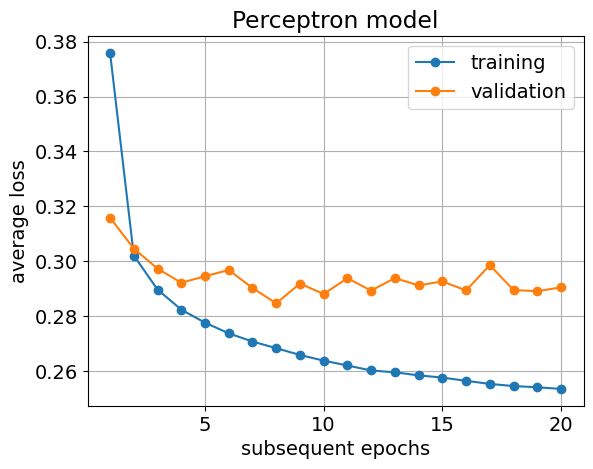

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Perceptron().to(device)

optimizer = optim.SGD(model.parameters(), lr=model_args['lr'], momentum=model_args['momentum'])
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss = []
validation_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss.append(train(model, device, train_loader, optimizer, epoch_number))
    validation_loss.append(test(model, device, validation_loader, 'Validation set'))

test(model, device, test_loader, 'Test set')
plot_loss(train_loss, validation_loss, 'Perceptron model')

2. For the model with geometric transformation rotation degree less than 45

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.523810
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.423465
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.277899
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.469546

Train set: Average loss: 1.4687
Validation set: Average loss: 1.4525, Accuracy: 5681/10000 (57%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.422933
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.631529
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.309533
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.397610

Train set: Average loss: 1.4346
Validation set: Average loss: 1.4630, Accuracy: 5626/10000 (56%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.296375
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.438268
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.393951
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.451410

Train set: Average loss: 1.4308
Validation set: Average loss: 1.4210, Accuracy: 5807/10000 (58%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.540016
Train Epoch: 4 [12800/50000 (26%)]	Loss: 1.171527
Train Epoch: 4 [25600/5

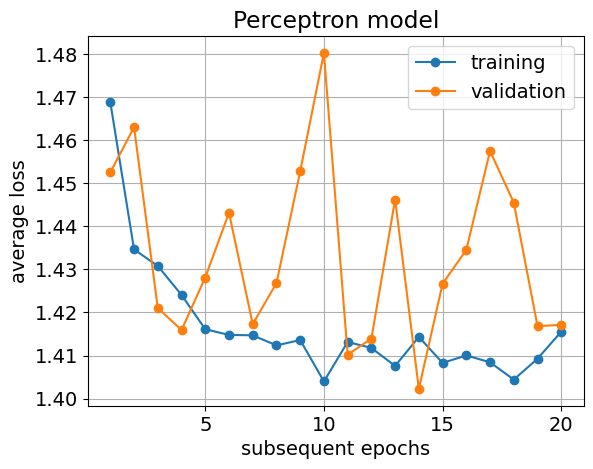

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Perceptron().to(device)

optimizer = optim.SGD(model.parameters(), lr=model_args['lr'], momentum=model_args['momentum'])
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss = []
validation_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss.append(train(model, device, train_loader, optimizer, epoch_number))
    validation_loss.append(test(model, device, validation_loader, 'Validation set'))

test(model, device, test_loader, 'Test set')
plot_loss(train_loss, validation_loss, 'Perceptron model')

3. For the model with geometric transformation greater than 45

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.357465
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.712364
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.624473
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.706518

Train set: Average loss: 1.6130
Validation set: Average loss: 1.5853, Accuracy: 5139/10000 (51%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.675997
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.677622
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.640983
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.837075

Train set: Average loss: 1.5933
Validation set: Average loss: 1.5925, Accuracy: 5154/10000 (52%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.234585
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.586953
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.704157
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.374826

Train set: Average loss: 1.5843
Validation set: Average loss: 1.5910, Accuracy: 5040/10000 (50%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.554668
Train Epoch: 4 [12800/50000 (26%)]	Loss: 1.588548
Train Epoch: 4 [25600/5

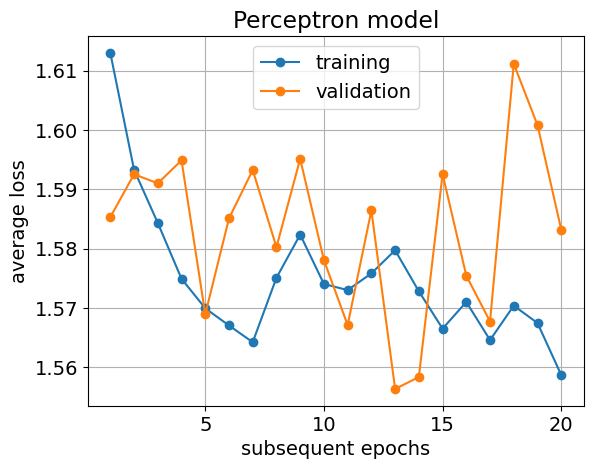

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Perceptron().to(device)

optimizer = optim.SGD(model.parameters(), lr=model_args['lr'], momentum=model_args['momentum'])
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss = []
validation_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss.append(train(model, device, train_loader, optimizer, epoch_number))
    validation_loss.append(test(model, device, validation_loader, 'Validation set'))

test(model, device, test_loader, 'Test set')
plot_loss(train_loss, validation_loss, 'Perceptron model')

2. Now add a hidden layer to the *Perceptron* and evaluate the *Deep* model 

1. For model with no geometric transformation

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.286548
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.267607
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.537100
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.475267

Train set: Average loss: 0.9225
Validation set: Average loss: 0.2500, Accuracy: 9244/10000 (92%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.362310
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.276523
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.216607
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.180450

Train set: Average loss: 0.2381
Validation set: Average loss: 0.1541, Accuracy: 9555/10000 (96%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.241122
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.131473
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.131741
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.156529

Train set: Average loss: 0.1595
Validation set: Average loss: 0.1179, Accuracy: 9640/10000 (96%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.029923
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.179050
Train Epoch: 4 [25600/5

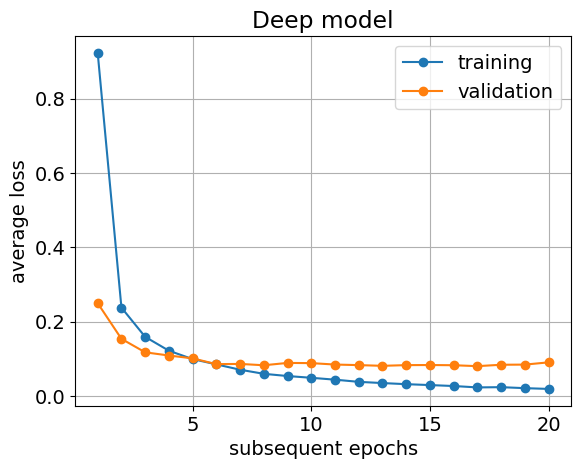

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Deep().to(device)

optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=model_args['momentum'])
                      #weight_decay=1.e-3)
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss = []
validation_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss.append(train(model, device, train_loader, optimizer, epoch_number))
    validation_loss.append(test(model, device, validation_loader, 'Validation set'))

test(model, device, test_loader, 'Test set')
plot_loss(train_loss, validation_loss, 'Deep model')

For the model with geometric transformation rotation less than 45

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.321167
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.180171
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.443216
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.303251

Train set: Average loss: 1.6813
Validation set: Average loss: 0.8245, Accuracy: 7301/10000 (73%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.897438
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.822601
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.639872
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.697890

Train set: Average loss: 0.7110
Validation set: Average loss: 0.4409, Accuracy: 8574/10000 (86%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.471735
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.520566
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.660546
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.466286

Train set: Average loss: 0.4860
Validation set: Average loss: 0.3287, Accuracy: 8987/10000 (90%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.382768
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.455870
Train Epoch: 4 [25600/5

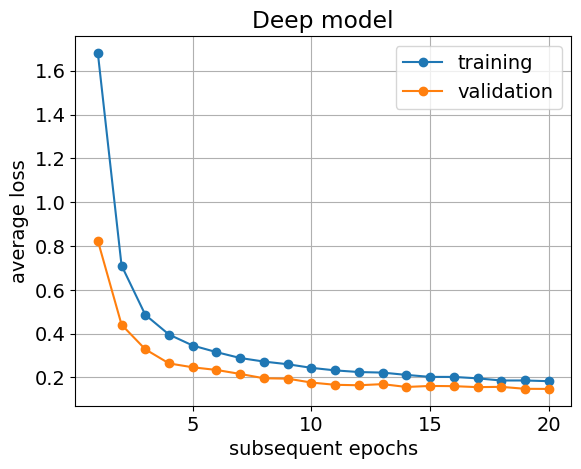

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Deep().to(device)

optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=model_args['momentum'])
                      #weight_decay=1.e-3)
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss = []
validation_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss.append(train(model, device, train_loader, optimizer, epoch_number))
    validation_loss.append(test(model, device, validation_loader, 'Validation set'))

test(model, device, test_loader, 'Test set')
plot_loss(train_loss, validation_loss, 'Deep model')

For the model with geometric transformation rotation greater than 45

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.299471
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.254171
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.737124
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.512241

Train set: Average loss: 1.7920
Validation set: Average loss: 1.1749, Accuracy: 5911/10000 (59%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.312660
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.285809
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.100039
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.177258

Train set: Average loss: 1.1127
Validation set: Average loss: 0.8827, Accuracy: 7064/10000 (71%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.697546
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.994654
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.092961
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.709059

Train set: Average loss: 0.8992
Validation set: Average loss: 0.7530, Accuracy: 7469/10000 (75%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.798096
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.916687
Train Epoch: 4 [25600/5

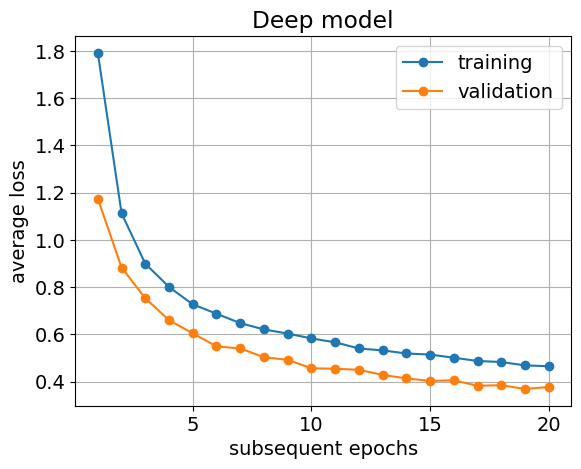

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Deep().to(device)

optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=model_args['momentum'])
                      #weight_decay=1.e-3)
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss = []
validation_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss.append(train(model, device, train_loader, optimizer, epoch_number))
    validation_loss.append(test(model, device, validation_loader, 'Validation set'))

test(model, device, test_loader, 'Test set')
plot_loss(train_loss, validation_loss, 'Deep model')

3. Compare these results with a deep convolutional network, which is more useful in real-world problems:

1. For model with no geometric transformation

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.321532
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.037334
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.500044
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.349393

Train set: Average loss: 0.7197
Validation set: Average loss: 0.1428, Accuracy: 9605/10000 (96%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.244518
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.248004
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.197133
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.133258

Train set: Average loss: 0.1895
Validation set: Average loss: 0.0781, Accuracy: 9770/10000 (98%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.319676
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.107374
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.105671
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.157943

Train set: Average loss: 0.1283
Validation set: Average loss: 0.0576, Accuracy: 9822/10000 (98%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.143726
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.170024
Train Epoch: 4 [25600/5

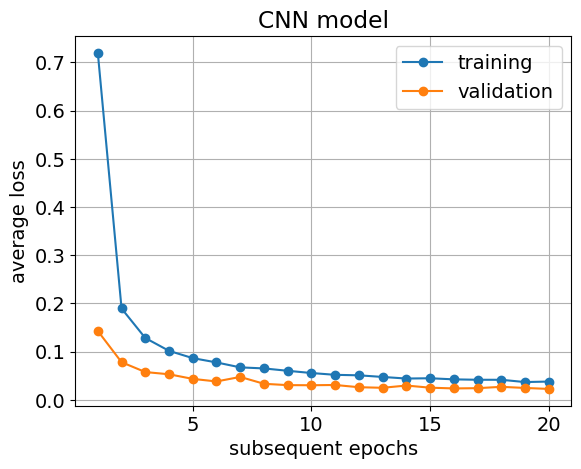

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)

optimizer = optim.SGD(model.parameters(), lr=model_args['lr'], momentum=model_args['momentum'])
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss = []
validation_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss.append(train(model, device, train_loader, optimizer, epoch_number))
    validation_loss.append(test(model, device, validation_loader, 'Validation set'))

test(model, device, test_loader, 'Test set')
plot_loss(train_loss, validation_loss, 'CNN model')

For the model with geometric transformation rotation less than 45

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.295089
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.100830
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.511932
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.527420

Train set: Average loss: 0.8774
Validation set: Average loss: 0.2883, Accuracy: 9173/10000 (92%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.300483
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.398292
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.208105
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.229361

Train set: Average loss: 0.2792
Validation set: Average loss: 0.1496, Accuracy: 9567/10000 (96%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.228157
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.283745
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.218953
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.285142

Train set: Average loss: 0.2049
Validation set: Average loss: 0.1164, Accuracy: 9670/10000 (97%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.182329
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.239727
Train Epoch: 4 [25600/5

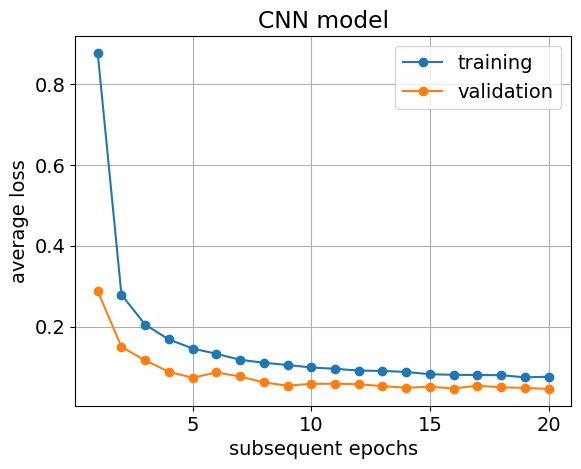

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)

optimizer = optim.SGD(model.parameters(), lr=model_args['lr'], momentum=model_args['momentum'])
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss = []
validation_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss.append(train(model, device, train_loader, optimizer, epoch_number))
    validation_loss.append(test(model, device, validation_loader, 'Validation set'))

test(model, device, test_loader, 'Test set')
plot_loss(train_loss, validation_loss, 'CNN model')

For the model with geometric transformation greater than 45

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.327159
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.649668
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.240571
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.036191

Train set: Average loss: 1.3058
Validation set: Average loss: 0.7452, Accuracy: 7765/10000 (78%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.800202
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.808648
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.833272
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.696281

Train set: Average loss: 0.7007
Validation set: Average loss: 0.4451, Accuracy: 8591/10000 (86%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.408248
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.564981
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.735227
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.342900

Train set: Average loss: 0.5370
Validation set: Average loss: 0.3693, Accuracy: 8796/10000 (88%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.406662
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.478965
Train Epoch: 4 [25600/5

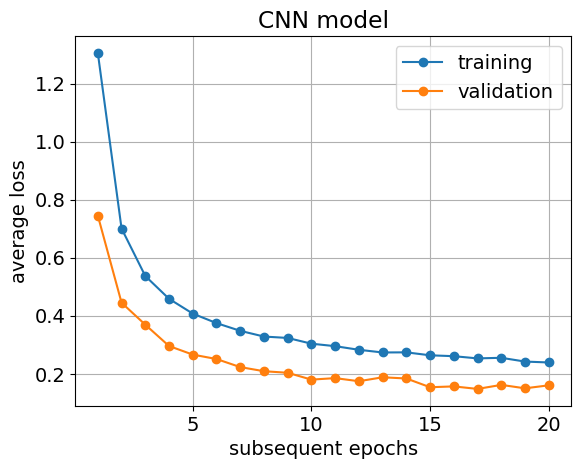

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)

optimizer = optim.SGD(model.parameters(), lr=model_args['lr'], momentum=model_args['momentum'])
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss = []
validation_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss.append(train(model, device, train_loader, optimizer, epoch_number))
    validation_loss.append(test(model, device, validation_loader, 'Validation set'))

test(model, device, test_loader, 'Test set')
plot_loss(train_loss, validation_loss, 'CNN model')